<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP

## Contents:
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Machine Learning Models](#Machine-Learning-Models)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Import libraries

In [157]:
import pandas as pd
import string
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

import pickle

## Data Cleaning

### Import Data

In [158]:
# Set the display option to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [159]:
# Import data from our web scrapping jupyter notebook
df = pd.read_csv("../data/df.csv")

In [160]:
# Class 0 = Avoidant
# Class 1 = Anxious

df.sample(10)

,Unnamed: 0,Title,Post Text,ID,Score,Total Comments,Post URL,subreddit,class
660,660,Good Podcast on Disorganized {FA},Just wanted to share [this great episode](http...,u9uc0o,22,8,https://www.reddit.com/r/AvoidantAttachment/co...,AvoidantAttachment,0
2990,1635,DA moving to the other side of the world,We aren't together anymore but one day my bf c...,11v9m8h,1,2,https://www.reddit.com/r/AnxiousAttachment/com...,AnxiousAttachment,1
1001,1001,DA - Personal Origins,"Hey guys,\n\nBeen made aware of my Dismissive...",15xmcbk,13,14,https://www.reddit.com/r/AvoidantAttachment/co...,AvoidantAttachment,0
2062,707,This Is Pure Wisdom,NaN,10hxerc,44,1,https://i.redd.it/mup6m43psfda1.png,AnxiousAttachment,1
1666,311,Have you ever had suicidal thoughts because yo...,NaN,xk49gb,76,21,https://www.reddit.com/r/AnxiousAttachment/com...,AnxiousAttachment,1
1508,153,Be cautious about viewing every relationship t...,"While we all have Attachment styles, sometimes...",v03orn,117,15,https://www.reddit.com/r/AnxiousAttachment/com...,AnxiousAttachment,1
1370,15,I see too many anxious people thinking they ar...,"Yes we must begin by loving ourselves, yes we ...",m3oirr,394,23,https://www.reddit.com/r/AnxiousAttachment/com...,AnxiousAttachment,1
1671,316,3 years of hard mental health work. I finally ...,"I went from disorganized to secure. Honestly, ...",125232t,75,14,https://i.redd.it/8to4o33s4lqa1.jpg,AnxiousAttachment,1
326,326,I kind of don’t get this sub,Why do so many anxiously attached people post ...,o7vunf,35,28,https://www.reddit.com/r/AvoidantAttachment/co...,AvoidantAttachment,0
203,203,Connection in Modernity {fa},I've been thinking a lot about connection in M...,10il4u8,46,16,https://www.reddit.com/r/AvoidantAttachment/co...,AvoidantAttachment,0


In [161]:
# Rename the 'Title' column
df["text"] = df["Title"]

In [162]:
# Check that the X values ('text' column) and y values ('class' column) do not have missing values
df.isna().sum()

Unnamed: 0          0
Title               0
Post Text         336
ID                  0
Score               0
Total Comments      0
Post URL            0
subreddit           0
class               0
text                0
dtype: int64

In [163]:
# Check the number of rows for each class
df["class"].value_counts()

1    1811
0    1355
Name: class, dtype: int64

In [164]:
# Dataframe info
df.describe()

,Unnamed: 0,Score,Total Comments,class
count,3166.000000,3166.000000,3166.000000,3166.000000
mean,807.419457,42.188566,17.218572,0.572015
std,484.376411,60.832831,23.687478,0.494865
min,0.000000,0.000000,0.000000,0.000000
25%,395.250000,11.000000,5.000000,0.000000
50%,791.000000,26.000000,11.000000,1.000000
75%,1186.750000,48.000000,21.000000,1.000000
max,1810.000000,983.000000,383.000000,1.000000


### Preprocessing

#### Remove special characters

In [165]:
# Remove punctuations and standardise to lowercase

def remove_punct(text):
    # store character only if it is not a punctuation
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

df["text_clean"] = df["text"].apply(lambda x: remove_punct(x.lower()))
df[["text", "text_clean"]].sample(5)

,text,text_clean
1814,I got back with my da partner with no fuss [up...,i got back with my da partner with no fuss update
305,The most avoidant {da} I’ve ever been,the most avoidant da i’ve ever been
3161,Need advice for dating someone with AA,need advice for dating someone with aa
519,Should I Keep Dating this Person?{FA} {DA},should i keep dating this personfa da
2549,Did they do you a favour?,did they do you a favour


#### Remove URLs

In [166]:
# Remove urls in the text column

def remove_url(text):
    text_nourl = re.sub(r'\S*http\S*', '', text)
    return text_nourl

df["text_clean"] = df["text_clean"].apply(lambda x: remove_url(x))

df[["text", "text_clean"]].sample(10)

,text,text_clean
626,What coping mechanisms did you develop on top ...,what coping mechanisms did you develop on top ...
1035,✨Wins and Success Thread ✨ {DA} {FA},✨wins and success thread ✨ da fa
654,{fa} I am scared that I will be treated the wa...,fa i am scared that i will be treated the way ...
908,fantasies safer than real life {fa},fantasies safer than real life fa
1009,How much time to spend with someone new? {fa},how much time to spend with someone new fa
2672,Possible progress in moving towards a more sec...,possible progress in moving towards a more sec...
136,Most guys give me (26F) the ick {FA},most guys give me 26f the ick fa
1062,Weekly Relationship Thread: Ask Avoidants,weekly relationship thread ask avoidants
2917,Journal entry about my avoidant ex. This is ho...,journal entry about my avoidant ex this is how...
2347,It’s crazy how NC have work so great for me si...,it’s crazy how nc have work so great for me si...


#### Remove words that contains digit

In [167]:
def remove_digit(text):
    text_nodigit = re.sub(r'\w*\d\w*', '', text)
    return text_nodigit

df["text_clean"] = df["text_clean"].apply(lambda x: remove_digit(x))

df[["text", "text_clean"]].sample(10)

,text,text_clean
2344,"How do you get over that ""used"" feeling?",how do you get over that used feeling
2657,today has been one of my weakest days in a lon...,today has been one of my weakest days in a lon...
592,"Emotions and detachment, disconnection",emotions and detachment disconnection
1151,How to process with therapist? {FA},how to process with therapist fa
1002,{DA}Books to help understand emotions,dabooks to help understand emotions
773,{FA} How do you manage getting triggered when ...,fa how do you manage getting triggered when yo...
152,Receiving = Losing,receiving losing
2813,"Thoughts on ""I'm super afraid that you'll stop...",thoughts on im super afraid that youll stop tr...
2185,Need help with making my relationship with my ...,need help with making my relationship with my ...
3123,I'm almost certain I need to break up with my ...,im almost certain i need to break up with my a...


#### Tokenize

In [168]:
def tokenize(text):  
    # /W matches any character that is neither alphanumeric nor underscoreb
    # Add a + just in case there are 2 or more spaces between certain words
    tokens = re.split('\W+', text)
    return tokens

df["text_token"] = df["text_clean"].apply(lambda x: tokenize(x)) 
df[["text", "text_token"]].sample(5)

,text,text_token
1547,Tip #1: Don't make them the center of your uni...,"[tip, dont, make, them, the, center, of, your,..."
2952,Share with me a lesson you’ve learned in your ...,"[share, with, me, a, lesson, you, ve, learned,..."
3085,How do you respond to jealousy in yourself?,"[how, do, you, respond, to, jealousy, in, your..."
855,{fa} How have you guys worked through the feel...,"[fa, how, have, you, guys, worked, through, th..."
1974,Anxiety or gut feeling?,"[anxiety, or, gut, feeling]"


#### Remove Stopwords

In [169]:
# List of default stopwords
stopword = nltk.corpus.stopwords.words('english')

# Remove stop words
def remove_stopwords(tokenized_list):
    #Store in text only if word is not found in stopword i.e. it is not a stopword
    text = [word for word in tokenized_list if word not in stopword]
    return text

df["text_stop"] = df["text_token"].apply(lambda x: remove_stopwords(x))
df[["text", "text_stop"]].sample(5)

,text,text_stop
548,"DA: Emotional avoidance, or autistic overwhelm?","[da, emotional, avoidance, autistic, overwhelm]"
1122,What does it mean to be emotionally available?...,"[mean, emotionally, available, fa]"
1000,FA help in queer/trans relationship,"[fa, help, queertrans, relationship]"
2992,Has anyone ever used psychedelics to heal/cure...,"[anyone, ever, used, psychedelics, healcure, a..."
2366,How would you answer this?,"[would, answer]"


#### Lemmatize

In [170]:
# Lemmatizer
wn = nltk.WordNetLemmatizer()

def lemmatizing(tokenized_text):
    #return list of all lemmatized words for their corresponding words in tokenized_text
    text = [wn.lemmatize(word) for word in tokenized_text]
    return ' '.join(text)

df["text_lemmatise"] = df["text_stop"].apply(lambda x: lemmatizing(x))
df[["text", "text_lemmatise"]].sample(5)

,text,text_lemmatise
2661,Need advice,need advice
868,Fantasizing about others as a deactivating str...,fantasizing others deactivating strategy fa
2210,Difference between dating a Secure vs DA style...,difference dating secure v da style partner
1258,Curious about your takes on this (Communicatio...,curious take communication segment fa da
374,{fa} For those that have made significant stri...,fa made significant stride toward security act...


#### Remove duplicate words

In [171]:
from nltk.tokenize import word_tokenize
df_1 = df[df["class"]==1]
df_0 = df[df["class"]==0]
class_text_1 = df_1["text_lemmatise"].tolist()

# Tokenize the text in the df
tokens_class_1 = []
for text in class_text_1:
    tokens_class_1.extend(word_tokenize(text))
class_text_0 = df_0["text_lemmatise"].tolist()

# Tokenize the text in the df
tokens_class_0 = []
for text in class_text_0:
    tokens_class_0.extend(word_tokenize(text))

# Reset Index
class_0_df =  pd.DataFrame(tokens_class_0).reset_index()
class_0_df.head()
class_0_df.columns = ['index',"words"]

# Group class 0 data by words
final_class_0 = pd.DataFrame(class_0_df.groupby("words")["words"].count().sort_values(ascending=False))
final_class_0.columns = ["count_of_class_0"]
final_class_0 = final_class_0.reset_index()

# Reset Index
class_1_df =  pd.DataFrame(tokens_class_1).reset_index()
class_1_df.head()
class_1_df.columns = ['index',"words"]

# Group class 1 data by words
final_class_1 = pd.DataFrame(class_1_df.groupby("words")["words"].count().sort_values(ascending=False))
final_class_1.columns = ["count_of_class_1"]
final_class_1 = final_class_1.reset_index()

In [172]:
# Merge both class 0 and class 1 and remove duplicated words between both classes
duplicate_words_df = pd.merge(final_class_0,final_class_1,how ="inner",on = "words")
duplicate_words_df['count_diff'] = (duplicate_words_df['count_of_class_0']- duplicate_words_df['count_of_class_1']).abs()
duplicate_words_df.columns=['Duplicate Words','Count (Class 0)', 'Count (Class 1)', 'Count Difference']

# Sort the DataFrame by the 'Count Difference' column in ascending order
duplicate_words_df = duplicate_words_df.sort_values(by='Count Difference',ascending=False)

duplicate_words_df

,Duplicate Words,Count (Class 0),Count (Class 1),Count Difference
0,fa,720,21,699
1,da,479,101,378
67,anxious,15,201,186
4,attachment,101,196,95
40,secure,22,97,75
5,avoidants,91,27,64
64,ex,16,74,58
75,anxiety,14,64,50
800,aa,1,49,48
32,dating,26,73,47


In [173]:
# Remove list of duplicate words that has count difference of 10 and below due to its insignificance in NLP)

additional_stopwords = duplicate_words_df[duplicate_words_df['Count Difference'].between(0, 10)]
stopword += additional_stopwords["Duplicate Words"].tolist()

df["text_final"] = df["text_token"].apply(lambda x: remove_stopwords(x))
df["text_final"] = df["text_final"].apply(lambda x: lemmatizing(x))

In [174]:
# These stopwords will be removed from df 
additional_stopwords.shape

(972, 4)

#### Data for Machine Learning

In [175]:
# Final df for machine learning 
df.head()

,Unnamed: 0,Title,Post Text,ID,Score,Total Comments,Post URL,subreddit,class,text,text_clean,text_token,text_stop,text_lemmatise,text_final
0,0,Seriously though {FA}{DA},NaN,tqnp1u,521,19,https://i.redd.it/vv5etnapy7q81.jpg,AvoidantAttachment,0,Seriously though {FA}{DA},seriously though fada,"[seriously, though, fada]","[seriously, though, fada]",seriously though fada,fada
1,1,For all my favorite avoidants ❤️,NaN,rpvbi1,453,2,https://i.redd.it/8yz268zr05881.jpg,AvoidantAttachment,0,For all my favorite avoidants ❤️,for all my favorite avoidants ❤️,"[for, all, my, favorite, avoidants, ]","[favorite, avoidants, ]",favorite avoidants,avoidants
2,2,Anxious People on this subreddit: stop abandon...,If you’re anxious preoccupied or anxious leani...,plr9xd,438,68,https://www.reddit.com/r/AvoidantAttachment/co...,AvoidantAttachment,0,Anxious People on this subreddit: stop abandon...,anxious people on this subreddit stop abandoni...,"[anxious, people, on, this, subreddit, stop, a...","[anxious, people, subreddit, stop, abandoning,...",anxious people subreddit stop abandoning blami...,anxious stop blaming someone else
3,3,Same {FA},NaN,syzhtu,345,6,https://i.redd.it/ta0rdmnlhgj81.jpg,AvoidantAttachment,0,Same {FA},same fa,"[same, fa]",[fa],fa,fa
4,4,❤️,NaN,s32vt3,330,5,https://v.redd.it/tmmv4r4hbhb81,AvoidantAttachment,0,❤️,❤️,"[, ]","[, ]",,


In [176]:
# Class 0 = Avoidant
# Class 1 = Anxious

df.shape

(3166, 15)

## Exploratory Data Analysis

#### EDA on Length of post

The distribution of the post length is right skewed, with most posts (75%) having 29 characters and less. On average, the length of posts in the "Anxious" subreddit are slightly shorter than those in the "Avoidant" subreddit.

In [177]:
# Create a new column called post_length that contains the length of each post
df['post_length'] = df['text_final'].map(len)

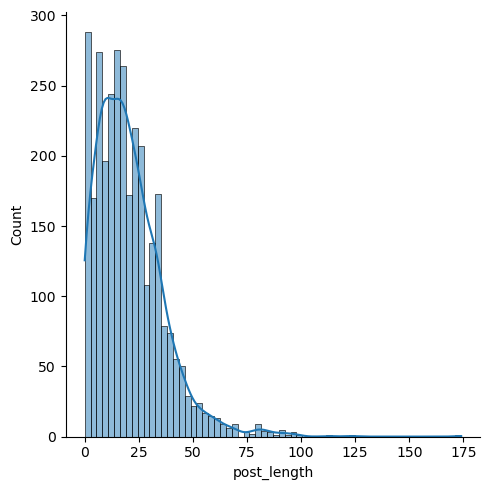

In [178]:
# Explore post_length on graphs
sns.displot(df['post_length'], kde=True)

In [179]:
# The average length of the post for Avoidant subreddits is 21 characters
df[df["class"] == 0]['post_length'].describe()

count    1355.000000
mean       21.685609
std        15.350751
min         0.000000
25%        10.000000
50%        19.000000
75%        30.000000
max       123.000000
Name: post_length, dtype: float64

In [180]:
# The average length of the post for Anxious subreddits is 19 characters
df[df["class"] == 1]['post_length'].describe()

count    1811.000000
mean       19.741579
std        15.881520
min         0.000000
25%         8.000000
50%        17.000000
75%        27.000000
max       174.000000
Name: post_length, dtype: float64

#### EDA on Word Count of post

The distribution of the post word count is right skewed, with most posts (75%) having 4 words and less. On average, the posts in the "Anxious" subreddit have lesser words than those in the "Avoidant" subreddit.

In [181]:
# Create a new column called post_word_count that contains the number of words in each post
df['post_word_count'] = df['text_final'].map(lambda x: len(x.split()))

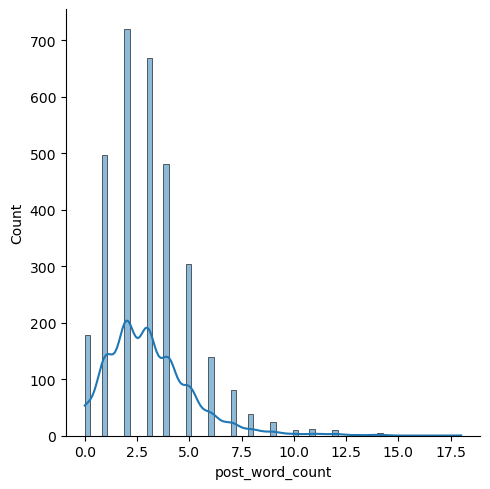

In [182]:
# Explore data on graphs
sns.displot(df['post_word_count'], kde=True)

In [183]:
# The average word count of the post for Avoidant subreddits is 3.4 words
df[df["class"] == 0]['post_word_count'].describe()

count    1355.000000
mean        3.409594
std         1.943378
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        14.000000
Name: post_word_count, dtype: float64

In [184]:
# The average word count of the post for Anxious subreddits is 2.8 words
df[df["class"] == 1]['post_word_count'].describe()

count    1811.000000
mean        2.830480
std         2.100639
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        18.000000
Name: post_word_count, dtype: float64

#### EDA on Posts Content

The longer posts tend to be those where the redditor share their experiences and are seeking advice/support. The shorter posts tend to be those where the redditor was sharing an URL/meme/video.

In [185]:
# Show the five longest posts based off of post_word_count
df.sort_values(by='post_word_count', ascending=False)[['text_final']].head()

,text_final
2077,partner responsive day unresponsive day attach...
1226,bf month attachment da thing going feel patter...
1404,quick im sorry avoidants deactivation attack w...
189,fa boyfriend shower word feel feel uncomfortab...
194,got dog month definitely he avoidant personali...


In [186]:
# Show the five shortest posts based off of post_word_count
# As digits and URLs were removed, thus the text shown is empty
df.sort_values(by='post_word_count', ascending=True)[['text_final']].head()

,text_final
2556,
595,
1384,
2206,
1391,


#### EDA on Post Score

In "Avoidant Style" subbreddit, the posts with the highest voting score are often content on the community showing support for the one another.  
In the "Anxious Style" subbreddit, the posts with the highest voting score are often content on sharing experiences and seeking support.

In [187]:
# Show the highest posts based on post scores
# Filter the DataFrame where 'Label' is equal to 0 (Avoidant Attachment style)
filtered_df = df[df['class'] == 0]

# Sort the filtered DataFrame by 'Score' in descending order and show the highest posts scores
highest_scores = filtered_df.sort_values(by='Score', ascending=False).head()

highest_scores['text']

0                            Seriously though {FA}{DA}
1                     For all my favorite avoidants ❤️
2    Anxious People on this subreddit: stop abandon...
3                                            Same {FA}
4                                                   ❤️
Name: text, dtype: object

In [188]:
# Show the highest posts based on post scores
# Filter the DataFrame where 'Label' is equal to 1 (Anxious Attachment style)
filtered_df = df[df['class'] == 1]

# Sort the filtered DataFrame by 'Score' in descending order and show the highest posts scores
highest_scores = filtered_df.sort_values(by='Score', ascending=False).head()

highest_scores['text']

1355                             Be a Magnet (not a rope)
1356    I’m dating someone secure, here’s the biggest ...
1357                              The struggle is real…..
1358                  Well if that isn’t a truth bomb lol
1359                              I’ll just leave it here
Name: text, dtype: object

#### EDA on Duplicated Words

As seen in the Venn diagram below, about half of the words in each class overlaps with the other class. In addition, the overlapping words have differing frequencies in each class (e.g. an overlapping word may predominately appear only in one class). To improve model peformance, 90% of the overlapping words with the lowest frequency difference (i.e. appeared equally in both classes) were removed.

In [189]:
from nltk.tokenize import word_tokenize

class_0_text = df[df["class"] == 0]["text_lemmatise"].tolist()
class_1_text = df[df["class"] == 1]["text_lemmatise"].tolist()
# Tokenize the post text for class 1
tokens_class_1 = []
for text in class_1_text:
    tokens_class_1.extend(word_tokenize(text))
# Tokenize the post text for class 0    
tokens_class_0 = []
for text in class_0_text:
    tokens_class_0.extend(word_tokenize(text))
    
unique_tokens_class_1 = set(tokens_class_1)
unique_tokens_class_0 = set(tokens_class_0)

print(f"Unique words in class 0: {len(unique_tokens_class_0)-len(duplicate_words_df)}")
print(f"Unique words in class 1: {len(unique_tokens_class_1)-len(duplicate_words_df)}")
print(f"Duplicate words in both classes: {len(duplicate_words_df)}")

Unique words in class 0: 904
Unique words in class 1: 1093
Duplicate words in both classes: 1050


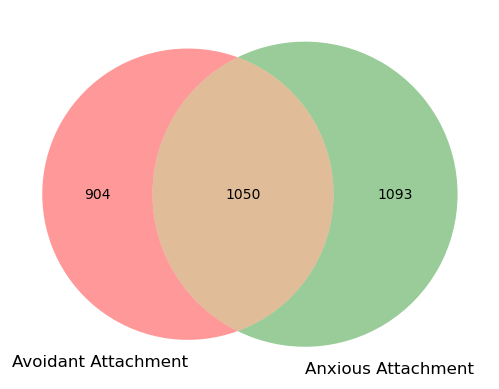

In [190]:
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

venn2(subsets = (904,1093,1050), set_labels = ('Avoidant Attachment', 'Anxious Attachment'))

#### Word Cloud - Avoidant Style

Some key words found in the "Avoidant" subreddit include "avoid", "dismissive".

In [191]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

duplicate_word_list = list(duplicate_words_df["Duplicate Words"])
class_1_words = [word for word in tokens_class_1 if word not in duplicate_word_list]

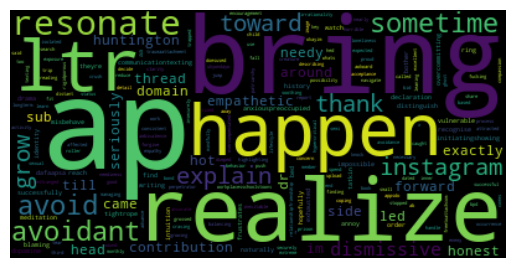

In [192]:
# Word Cloud to show the most common words that appeared in the subreddit
# For Avoidant Attachment class 0

class_0_words = [word for word in tokens_class_0 if word not in duplicate_word_list]

text = " ".join(unique_tokens_class_0)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Word Cloud - Anxious Style

Some key words found in the "Anxious" subreddit include "responsiveness", "breakup", 'overthinking'.

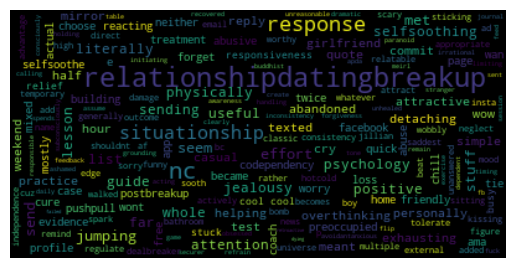

In [193]:
# Word Cloud to show the most common words that appeared in the subreddit
# For Anxious Attachment class 1
text = " ".join(class_1_words)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Machine Learning Models

We ran a series of machine learning models with different vectorization methods such as Count Vetorization and TF-IDF Vectorization to get the optimal performance for our predictor model.  

Machine learning models used as Naive Bayes models (Bernoulli and Multinomial) and Logistic Regression.  
  
With GridSearchCV, we obtained the best combination of hyperparameters for optimal model performance.  

### Count Vectorizer & Naive Bayes (Bernoulli) Pipeline

#### Baseline Model 

This is the first learning model we ran and it is used as a baseline for model performance.  
Accuracy: Our model achieved an accuracy of 0.88, which means it correctly classified roughly 88% of the samples in the test dataset. It appears to perform reasonably well with an accuracy of 0.88, but it's important to predict both class accurately as each class (avoidant and anxious attachment style) have vastly different behaviours and motivations when they approach matters like conflicts and relationship matters. Thus, we may want to further optimize the model or explore more advanced algorithms and feature engineering techniques to improve its performance.

In [194]:
# Initiate train, test, split function
X = df['text_final']
y = df['class']

# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42)

In [195]:
# Create a pipeline for Count Vectorizer and Naive Bayes (Bernoulli)
pipe_cv_berNB = Pipeline([
    ('cvec',  CountVectorizer()),
    ('berNB', BernoulliNB())])
# Define hyperparameters for grid search
pipe_cv_berNB_params = {'cvec__max_features' : [500],  # 100
                        'cvec__ngram_range' : [(1,2)], #(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)
                       'berNB__binarize': [0.0]}       # 0.1, 0.5

# Instantiate GridSearchCV
gs_cv_berNB = GridSearchCV(pipe_cv_berNB, pipe_cv_berNB_params, cv=5)

# Fit GridSearch to training data
gs_cv_berNB.fit(X_train, y_train)

# Best score
print (f'Best Score: {gs_cv_berNB.best_score_}')

# Best parameters
print (f'Best Parameters: {gs_cv_berNB.best_params_}')

# Training score
print (f'Train Score: {gs_cv_berNB.score(X_train, y_train)}')

# Test score
print (f'Test Score: {gs_cv_berNB.score(X_test, y_test)}')

# y predict
y_pred_gs_cv_berNB = gs_cv_berNB.predict(X_test)
print(classification_report(y_test, y_pred_gs_cv_berNB))

Best Score: 0.8816309127248501
Best Parameters: {'berNB__binarize': 0.0, 'cvec__max_features': 500, 'cvec__ngram_range': (1, 2)}
Train Score: 0.9001684919966302
Test Score: 0.8787878787878788
              precision    recall  f1-score   support

           0       0.94      0.76      0.84       339
           1       0.85      0.96      0.90       453

    accuracy                           0.88       792
   macro avg       0.89      0.86      0.87       792
weighted avg       0.89      0.88      0.88       792



### Count Vectorizer & Naive Bayes (Multinomial) Pipeline

In [196]:
# Create a pipeline for Count Vectorizer and Naive Bayes (Multinomial)
pipe_cv_multiNB = Pipeline([
    ('cvec',  CountVectorizer()), 
    ('multiNB', MultinomialNB())])

# Define hyperparameters for grid search
pipe_cv_multiNB_params = {'cvec__max_features' : [100,500],  # comment what you have tried
                        'cvec__ngram_range' : [(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)]}
                        

# Instantiate GridSearchCV    
gs_cv_multiNB = GridSearchCV(pipe_cv_multiNB, pipe_cv_multiNB_params, cv=5)

# Fit GridSearch to training data
gs_cv_multiNB.fit(X_train, y_train)

# Best score
print (f'Best Score: {gs_cv_multiNB.best_score_}')

# Best parameters
print (f'Best Parameters: {gs_cv_multiNB.best_params_}')

# Training score
print (f'Train Score: {gs_cv_multiNB.score(X_train, y_train)}')

# Test score
print (f'Test Score: {gs_cv_multiNB.score(X_test, y_test)}')

# y predict
y_pred_gs_cv_multiNB = gs_cv_multiNB.predict(X_test)
print(classification_report(y_test, y_pred_gs_cv_multiNB))

Best Score: 0.8723668665334221
Best Parameters: {'cvec__max_features': 500, 'cvec__ngram_range': (1, 1)}
Train Score: 0.9048020219039595
Test Score: 0.8813131313131313
              precision    recall  f1-score   support

           0       0.89      0.82      0.86       339
           1       0.87      0.92      0.90       453

    accuracy                           0.88       792
   macro avg       0.88      0.87      0.88       792
weighted avg       0.88      0.88      0.88       792



### Count Vectorizer & Logistic Regression Model

#### Best Model

In [197]:
def cvcvectorize_split_smote_logistic(X, y, test_size=0.4, random_state=42):
    # Step 1: Apply Count Vectorizer
    vectorizer = CountVectorizer(max_features=600, min_df=2, max_df=.9, ngram_range=(1,2))
    X_vectorized = vectorizer.fit_transform(X)
    
    # Parameters tested
    # max_features: [500, 2_000, 3_000, 4_000, 5_000]
    # min_df: [3]
    # max_df: [.95]
    # ngram_range:[(1,1) (2,2)]

    
    # Step 2: Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=test_size, random_state=random_state)
    
    
    # Step 3: Apply SMOTE to the training data
    smote = SMOTE(random_state=random_state)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    
    # Step 4: Train a logistic regression model
    classifier = LogisticRegression(solver='liblinear')
    classifier.fit(X_train_resampled, y_train_resampled) 
    
    
    #Step 5: Retrieve the coefficient and feature names 
    coef = classifier.coef_[0]
    features = vectorizer.get_feature_names_out() 
    feature_importance = pd.DataFrame({'Features': features, 'Importance': coef})
    # Separate positive and negative coefficients
    positive_coeffs = feature_importance[feature_importance['Importance'] > 0]
    negative_coeffs = feature_importance[feature_importance['Importance'] < 0]
    # Find the smallest positive coefficient
    largest_positive_coeff = positive_coeffs.nlargest(50, 'Importance')
    # Find the highest negative coefficient
    smallest_negative_coeff = negative_coeffs.nsmallest(50, 'Importance')
    
    
    # Step 6: Evaluate on training and test data
    train_predictions = classifier.predict(X_train_resampled)
    test_predictions = classifier.predict(X_test)
    
    train_accuracy = accuracy_score(y_train_resampled, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)
    
    # Score model on training set
    print(f'Train Score: {train_accuracy}')
    
    # Score model on testing set
    print(f'Test Score: {test_accuracy}')
    
    # Making predictions
    print(classification_report(y_test, test_predictions))
    
    # Pickle out the vectorizer and the model for streamlit in the streamlit folder.
    pickle.dump(vectorizer,open('../streamlit/our_vectorizer.pkl','wb'))
    pickle.dump(classifier,open('../streamlit/our_model.pkl','wb'))
    
    return train_accuracy, test_accuracy, smallest_negative_coeff, largest_positive_coeff


# Invoke Function 
cvcvectorize_split_smote_logistic(X,y)

Train Score: 0.894090909090909
Test Score: 0.8950276243093923
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       556
           1       0.89      0.93      0.91       711

    accuracy                           0.90      1267
   macro avg       0.90      0.89      0.89      1267
weighted avg       0.90      0.90      0.89      1267



(0.894090909090909,
 0.8950276243093923,
                 Features  Importance
 179                   fa   -4.747432
 109                   da   -2.816274
 50             avoidance   -2.295773
 207                 fada   -1.905943
 142         deactivating   -1.874534
 30         ask avoidants   -1.748745
 131                 dafa   -1.662415
 455                   sa   -1.600877
 23       anxious partner   -1.473009
 290             intimacy   -1.458955
 67             avoidants   -1.275914
 52              avoidant   -1.221619
 163              emotion   -1.163432
 367               parent   -1.116756
 453                 rule   -1.077500
 15          anxiety feel   -1.056157
 512                 take   -0.997954
 49                 avoid   -0.978497
 144         deactivation   -0.969989
 118           da feeling   -0.958888
 55   avoidant attachment   -0.927890
 301                   le   -0.915653
 588                 work   -0.913937
 177              express   -0.859824
 561     

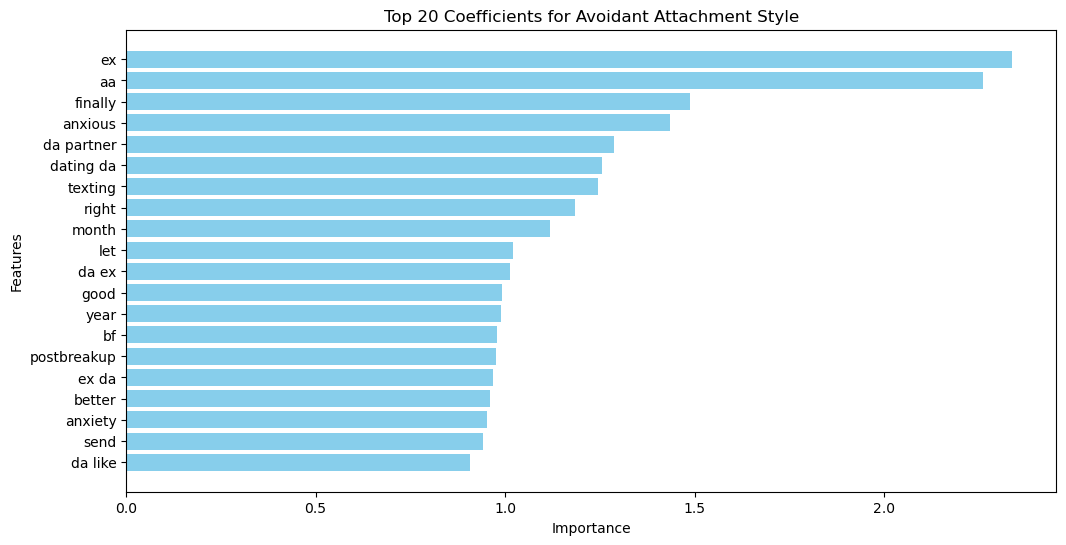

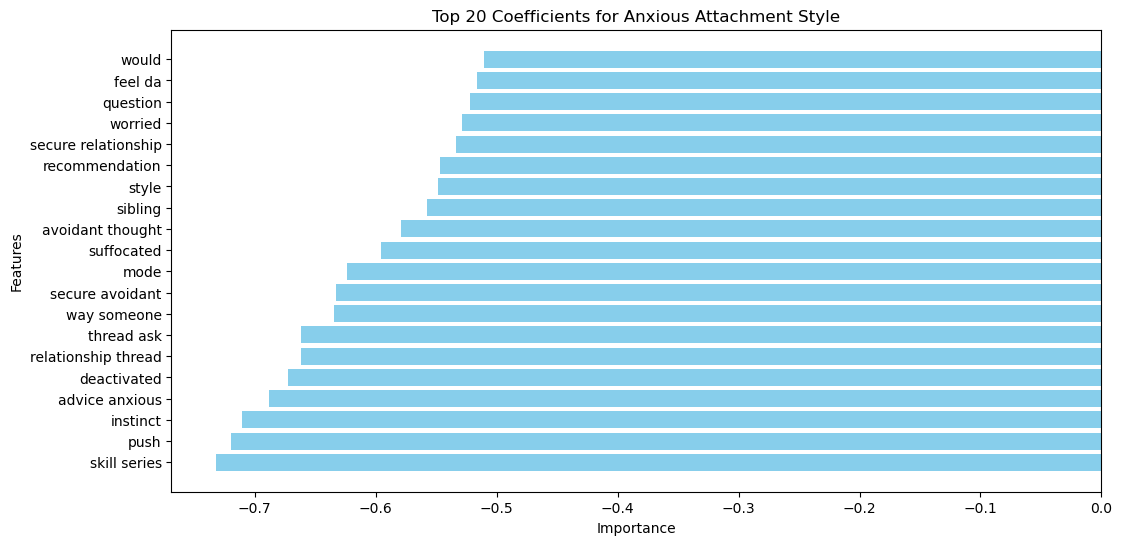

In [200]:
# Plot graph with strongest co-efficient words for each class

def plot_feature_importance(feature_importance, title):
    # Sort the feature importance values in descending order
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    # Create a bar chart
    plt.figure(figsize=(12, 6))
    plt.barh(feature_importance['Features'][:20], feature_importance['Importance'][:20], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert the y-axis to show the most important features at the top
    plt.show()

# Plot the largest positive coefficients
plot_feature_importance(largest_positive_coeff, 'Top 20 Coefficients for Avoidant Attachment Style')
# Plot the smallest negative coefficients
plot_feature_importance(smallest_negative_coeff, 'Top 20 Coefficients for Anxious Attachment Style')

Some top feature coefficients with high prediction importance for Avoidant Attachment Style are 'push', 'deactivated' and 'suffocated'while some top feature coefficients with high prediction importance for Anxious Attachment Style are 'anxiety', 'postbreakup', 'texting' and 'anxious'.

### TF-IDF Vectorizer & Logistic Regression Model

In [201]:
def tfidvectorize_split_smote_logistic(X, y, test_size=0.4, random_state=42):
    # Step 1: Apply Tfidf Vectorizer
    vectorizer = TfidfVectorizer(max_features=600, min_df=2, max_df=.9, ngram_range=(1,2))
    X_vectorized = vectorizer.fit_transform(X)
    
    # Parameters tested
    # max_features: [500, 2_000, 3_000, 4_000, 5_000]
    # min_df: [3]
    # max_df: [.95]
    # ngram_range:[(1,1) (2,2)]

    
    # Step 2: Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=test_size, random_state=random_state)
    
    
    # Step 3: Apply SMOTE to the training data
    smote = SMOTE(random_state=random_state)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    
    # Step 4: Train a logistic regression model
    classifier = LogisticRegression(solver='liblinear')
    classifier.fit(X_train_resampled, y_train_resampled) 
    
    
    # Step 5: Evaluate on training and test data
    train_predictions = classifier.predict(X_train_resampled)
    test_predictions = classifier.predict(X_test)
    
    train_accuracy = accuracy_score(y_train_resampled, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)
    
    # Score model on training set
    print(f'Train Score: {train_accuracy}')
    
    # Score model on testing set
    print(f'Test Score: {test_accuracy}')
    
    # Making predictions
    print(classification_report(y_test, test_predictions))
    
    return train_accuracy, test_accuracy


# Invoke Function 
tfidvectorize_split_smote_logistic(X,y)

Train Score: 0.8827272727272727
Test Score: 0.8871349644830308
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       556
           1       0.87      0.94      0.90       711

    accuracy                           0.89      1267
   macro avg       0.89      0.88      0.88      1267
weighted avg       0.89      0.89      0.89      1267



(0.8827272727272727, 0.8871349644830308)

## Conclusions and Recommendations

Learning Model Results:  
| Models | Train accuracy | Test accuracy | Precision | Recall | F1 Score | 
|----------|----------|----------|----------|----------|----------|
| Naive Bayes Bernoulli (With Count Vectorizer) | 0.90 | 0.88 | 0.85 | 0.96 | 0.90 |
| Naive Bayes Multinomial (With Count Vectorizer) | 0.90 | 0.88 | 0.87 | 0.92 | 0.90 | 
| <b>Logistic Regression (With Count Vectorizer)</b> | <b>0.90</b> | <b>0.90</b> | <b>0.89</b> | <b>0.93</b> | <b>0.91</b> |
| Logistic Regression (With TF-IDF Vectorizer) | 0.88 | 0.89 | 0.87 | 0.94 | 0.90 |

Logistic Regression model with Count Vectorizer achieved the best prediction performance amongst other learning models and vectorization methods that we have attempted. With the application of SMOTE to upsize class 0 dataset to prevent class imbalance and hyperparameters tuning, the combination of max_features=600, min_df=2, max_df=.9, ngram_range=(1,2) gives us a train, test accuracy score of 0.9 with no overfitting or underfitting of data.  
  
Accuracy of the model is the most important criteria when we are evaluating the performance of the model. As both attachment styles handles relationship matters such as conflicts and feelings very differently, it is equally important to predict both behaviours correctly.

As reference from Columbia Psychiatry, adult attachment theory posits that your attachment style as an adult affects how you behave in close, romantic relationships and by understanding attachment styles of yourself and partner, it allows room for change and growth in improving relationships. Link: https://www.columbiapsychiatry.org/news/how-attachment-styles-influence-romantic-relationships

Recommendations:  
  
Phase 1 - First release of the app on:  
-MSF website  
-MSF’s Telegram channel (i.e.,MSFCares)

Phase 2 - Improve accuracy of classifier model to ≥0.95 through:  
-exploring ways to tune the existing classifier model;  
-exploring the use of other classifier models (e.g., XGBoost)
  
Phase 3 -Second release of the app with:  
-expanded coverage of the other two attachment styles